In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# initialization

In [2]:
BATCH_SIZE=1
time_step=30 #data of prevoius 29 hours + current data
EPOCH=25
n_features = 7 #day month year weekday hour temperature previous_hour_load

# load data

In [3]:
# to know more about x and y you can check preprocessing.ipynb code
import pickle
pic_in=open("./data/x.pickle","rb")
x=pickle.load(pic_in)

pic_in=open("./data/y.pickle","rb")
y=pickle.load(pic_in)

print(x.shape)
print(y.shape)

(103776, 6)
(103776,)


# preprocess data

In [4]:
x=np.hstack((x[1:],y[:-1].reshape(-1,1))) #adding previous_hour_load as a new feature
x.shape

(103775, 7)

In [5]:
#scaling between 0 to 1
x=MinMaxScaler(feature_range=(0,1)).fit_transform(x)

In [6]:
#adding time step
from collections import deque
prev=deque(maxlen=time_step)
for i in range(time_step-1):
    prev.append(list(x[i]))
    
xx=list()
for i in range(time_step-1,len(x)):
    prev.append(list(x[i]))
    xx.append(list(prev))

In [7]:
#corresponding output data
y=y[time_step:]

In [8]:
print(y.min(),y.max()) #this data is required for inverse scaling

7794.0 27622.0


In [9]:
xx=np.array(xx)
print(xx.shape)
print(y.shape)
print(type(xx))
print(type(y))

(103746, 30, 7)
(103746,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# scaling and splitting

In [10]:
#scaling the output (demand of current hour)
scale=MinMaxScaler(feature_range=(0,1))
y=scale.fit_transform(y.reshape(-1,1))
#minmaxscaler formula=(x-xmin)/(xmax-xmin)

In [11]:
#input shape (sample,time step, feature)
#splitting in train and test set.93% as train and 7% as test data
train_test_split=int(len(xx)*0.93)
x_test=xx[train_test_split:]
x_train=xx[:train_test_split]
print(x_test.shape)
print(x_train.shape)

y_test=y[train_test_split:]
y_train=y[:train_test_split]
print(y_test.shape)
print(y_train.shape)

(7263, 30, 7)
(96483, 30, 7)
(7263, 1)
(96483, 1)


# model

In [12]:
from keras.layers import Dense,Activation,Dropout,LSTM,BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [13]:
batch_size=BATCH_SIZE
model=Sequential()

#lstm layer 1
model.add(LSTM(64,batch_input_shape=(batch_size,x_train.shape[1],x_train.shape[2]),stateful=True,return_sequences=True))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))
model.add(BatchNormalization())

#lstm layer 2
model.add(LSTM(128,batch_input_shape=(batch_size,x_train.shape[1],x_train.shape[2]),stateful=True,return_sequences=True))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))
model.add(BatchNormalization())

#lstm layer 3
model.add(LSTM(256,batch_input_shape=(batch_size,x_train.shape[1],x_train.shape[2]),stateful=True,return_sequences=True))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))
model.add(BatchNormalization())

#lstm layer 4
model.add(LSTM(256,batch_input_shape=(batch_size,x_train.shape[1],x_train.shape[2]),stateful=True,return_sequences=True))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))
model.add(BatchNormalization())

#lstm layer 5
model.add(LSTM(128,batch_input_shape=(batch_size,x_train.shape[1],x_train.shape[2]),stateful=True,return_sequences=True))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))
model.add(BatchNormalization())

#lstm layer 6
model.add(LSTM(64,batch_input_shape=(batch_size,x_train.shape[1],x_train.shape[2]),stateful=True,return_sequences=False))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))
model.add(BatchNormalization())

#dense layer 7
model.add(Dense(32))
model.add(LeakyReLU(alpha=0.1))

#output layer
model.add(Dense(1,activation='linear'))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 30, 64)               18432     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (1, 30, 64)               0         
_________________________________________________________________
dropout_1 (Dropout)          (1, 30, 64)               0         
_________________________________________________________________
batch_normalization_1 (Batch (1, 30, 64)               256       
_________________________________________________________________
lstm_2 (LSTM)                (1, 30, 128)              98816     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (1, 30, 128)              0         
_________________________________________________________________
dropout_2 (Dropout)          (1, 30, 128)             

# loading pre-trained weight

In [15]:
model.load_weights('./data/weight.h5')

# or training from scratch

In [25]:
model.compile(Adam(lr=0.0008,decay=1e-5),loss='mean_squared_error',metrics=['mae','mse'])

In [26]:
for i in range(20):
    model.fit(x_train,y_train,epochs=1,batch_size=batch_size,shuffle=False,verbose=1)
    model.reset_states()

Epoch 1/1
93395/93395 [==============================] - 2027s 22ms/step - loss: 0.0174 - mae: 0.1112 - mse: 0.0174
Epoch 1/1
  140/93395 [..............................] - ETA: 31:30 - loss: 0.0172 - mae: 0.1147 - mse: 0.0172 E

KeyboardInterrupt: 

In [ ]:
model.save_weights('./data/new_weight.h5')

# testing

In [16]:
#predict on test dataset
y_pred=model.predict(x_test, batch_size=batch_size)
model.reset_states()

In [17]:
x_axis=np.linspace(1,len(y_pred),len(y_pred))
print(x_axis.shape)
y_pred=y_pred.reshape(-1)
y_test=y_test.reshape(-1)
#inverse scaling, here ymax=27622 and ymin=7794
y_test=y_test*(27622-7794)+7794
y_pred=y_pred*(27622-7794)+7794
print(y_pred.shape)
print(y_test.shape)

(7263,)
(7263,)
(7263,)


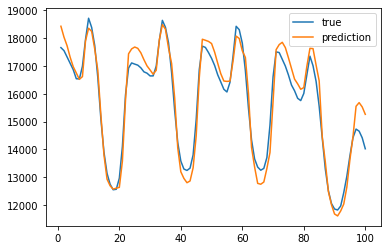

In [18]:
plt.plot(x_axis[:100],y_test[:100])
plt.plot(x_axis[:100],y_pred[:100])
plt.legend(['true','prediction'])
plt.show()

In [19]:
print(y_pred[5])
print(y_test[5])

16749.05
16542.0


# check fitting on train dataset

In [20]:
#predict on train dataset
ytrain_pred=model.predict(x_train, batch_size=batch_size)
model.reset_states()

In [21]:
x_axis2=np.linspace(1,len(ytrain_pred),len(ytrain_pred))
print(x_axis2.shape)
ytrain_pred=ytrain_pred.reshape(-1)
y_train=y_train.reshape(-1)
#inverse scaling, here ymax=27622 and ymin=7794
y_test=y_test*(27622-7794)+7794
y_pred=y_pred*(27622-7794)+7794
print(ytrain_pred.shape)
print(y_train.shape)

(96483,)
(96483,)
(96483,)


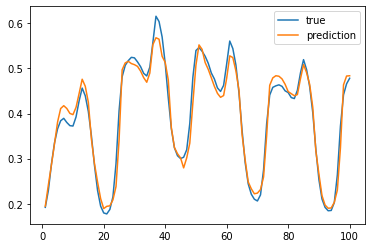

In [22]:
plt.plot(x_axis2[:100],y_train[:100])
plt.plot(x_axis2[:100],ytrain_pred[:100])
plt.legend(['true','prediction'])
plt.show()